In [1]:
import sys
sys.path.append('../')
import pickle
import re
import glob
import os

import time

import theano
import theano.tensor as T
import numpy as np
import pandas as p
import lasagne as nn

from utils import hms, architecture_string, get_img_ids_from_iter

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [2]:
!gcc --version

gcc (Ubuntu 4.8.5-4ubuntu8~16.04.1) 4.8.5
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
!which nvcc

/usr/local/cuda-7.0/bin/nvcc


In [4]:
!python --version

Python 2.7.16 :: Anaconda, Inc.


In [4]:
!git clone https://github.com/Theano/Theano
%cd Theano
!git checkout 9a653e3e91c0e38b6643e4452199931e792a24a2
!pip install .
%cd ..

fatal: destination path 'Theano' already exists and is not an empty directory.
/users/avanti/kaggle_diabetic_retinopathy/notebooks/Theano
HEAD is now at 9a653e3... Merge pull request #3150 from caglar/theano_shared_zero2
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
Processing /users/avanti/kaggle_diabetic_retinopathy/notebooks/Theano
  Stored in directory: /tmp/pip-ephem-wheel-cache-88DvGn/wheels/2e/80/ce/e61c44e4fc9a975b404057b2fe01224d2ea79dec59f36d64ec
Successfully built Theano
  Found existing installation: Theano 0.7.0
    Uninstalling Theano-0.7.0:
      Successfully uninstalled Theano-0.7.0
/users/avanti/kaggle_diabetic_retinopathy/notebooks


In [5]:
!git clone https://github.com/Lasagne/Lasagne
%cd Lasagne
!git checkout cf1a23c21666fc0225a05d284134b255e3613335
!pip install .
%cd ..

fatal: destination path 'Lasagne' already exists and is not an empty directory.
/users/avanti/kaggle_diabetic_retinopathy/notebooks/Lasagne
HEAD is now at cf1a23c... Merge pull request #278 from skaae/add_embedding_doc
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
Processing /users/avanti/kaggle_diabetic_retinopathy/notebooks/Lasagne
  Stored in directory: /tmp/pip-ephem-wheel-cache-NQqxkB/wheels/41/17/42/bed688d24ee7c4d3f5638aa526295c91eba55d8d3aec20e9b1
Successfully built Lasagne
  Found existing installation: Lasagne 0.1.dev0
    Uninstalling Lasagne-0.1.dev0:
      Successfully uninstalled Lasagne-0.1.dev0
/users/avanti/kaggle_diabetic_retinopathy/notebooks


In [5]:
!conda list

# packages in environment at /users/avanti/anaconda3/envs/py2diabeticretinopathy:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
attrs                     19.1.0                   py27_1  
backports                 1.0                        py_2  
backports.shutil_get_terminal_size 1.0.0                    py27_2  
backports_abc             0.5                        py_0  
blas                      1.0                         mkl  
bleach                    3.1.0                    py27_0  
ca-certificates           2019.5.15                     0  
cairo                     1.12.18                       0  
certifi                   2019.6.16                py27_1  
configparser              3.7.4                    py27_0  
cycler                    0.10.0                   py27_0  
cython                    0.17                     pypi_0    pypi
dateutil                  2.4.1                    py2

First we load the dump of the trained network.

In [6]:
dump_path = '../dumps/2015_07_17_123003.pkl'

In [7]:
model_data = pickle.load(open(dump_path, 'r'))

Some info about the architecture of the model:

In [9]:
model_arch = architecture_string(model_data['l_out'])

num_params = nn.layers.count_params(model_data['l_out'])
model_arch += "\nNumber of parameters: %d.\n\n" % num_params
print(model_arch)

   0  InputLayer                   (64, 3, 512, 512)  
   1  Conv2DDNNLayer               (64, 32, 256, 256)  7 //2
   2  MaxPool2DDNNLayer            (64, 32, 127, 127)  3 //2
   3  Conv2DDNNLayer               (64, 32, 127, 127)  3 //1
   4  Conv2DDNNLayer               (64, 32, 127, 127)  3 //1
   5  MaxPool2DDNNLayer            (64, 32, 63, 63)  3 //2
   6  Conv2DDNNLayer               (64, 64, 63, 63)  3 //1
   7  Conv2DDNNLayer               (64, 64, 63, 63)  3 //1
   8  MaxPool2DDNNLayer            (64, 64, 31, 31)  3 //2
   9  Conv2DDNNLayer               (64, 128, 31, 31)  3 //1
  10  Conv2DDNNLayer               (64, 128, 31, 31)  3 //1
  11  Conv2DDNNLayer               (64, 128, 31, 31)  3 //1
  12  Conv2DDNNLayer               (64, 128, 31, 31)  3 //1
  13  MaxPool2DDNNLayer            (64, 128, 15, 15)  3 //2
  14  Conv2DDNNLayer               (64, 256, 15, 15)  3 //1
  15  Conv2DDNNLayer               (64, 256, 15, 15)  3 //1
  16  Conv2DDNNLayer               (64, 256, 

Setting up some Theano / Lasagne things to get some predictions.

In [10]:
l_out = model_data['l_out'].input_layer #getting pre-softmax output
l_ins = model_data['l_ins']
output = nn.layers.get_output(l_out, deterministic=True) 
nondeterministic_output = nn.layers.get_output(l_out, deterministic=False)
compute_output = theano.function(
    [x.input_var for x in l_ins],
    output,
    on_unused_input='ignore')
compute_nondeterministic_output = theano.function(
    [x.input_var for x in l_ins],
    nondeterministic_output,
    on_unused_input='ignore')

In [11]:
train_labels = p.read_csv(os.path.join('/srv/scratch/avanti/diabetic_retinopathy/trainLabels.csv'))

In [12]:
train_labels

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
5,15_right,2
6,16_left,4
7,16_right,4
8,17_left,0
9,17_right,1


The validation set is a specific subset of the training set, so load the train labels

In [13]:
image_to_label = dict(zip(train_labels.image, train_labels.level))
new_dataloader_params = model_data['data_loader_params']
train_image_ids = set(new_dataloader_params['images_train_0'])
# Get validation set ids
all_patient_ids = sorted(set(get_img_ids_from_iter(train_labels.image)))
valid_patient_ids = [patient_id for patient_id in all_patient_ids
                     if patient_id not in train_image_ids]

In [14]:
from PIL import Image
def load_and_resize_image(image_path, output_shape,
                          zmuv_mean, zmuv_std):
    im = Image.open(image_path, mode='r')
    sort_dim = list(np.sort(im.size))

    im_new = im
    if im_new.size != output_shape:
        im_new = im_new.resize(output_shape, resample=Image.BILINEAR)
    im_new = np.asarray(im_new).astype('float32')/255  
    im.close()
    
    im_new = (im_new - zmuv_mean)/(0.05 + zmuv_std)    
    return im_new, (sort_dim[1] / 700.0, sort_dim[0] / 700.0)

def get_image_batch_generator(image_paths, batch_size, output_shape, zmuv_mean, zmuv_std,
                              xyflip, horizontalflip, verticalflip):
    batch_idx = 0
    while (batch_idx*batch_size < len(image_paths)):
        image_batch = []
        dims_batch = []
        for i in range(batch_size):
            if ((batch_size*batch_idx + i) < len(image_paths)):
                image_path = image_paths[batch_size*batch_idx + i]
                im, dim = load_and_resize_image(image_path=image_path,
                                                output_shape=output_shape,
                                                zmuv_mean=zmuv_mean,
                                                zmuv_std=zmuv_std)
                im = np.rollaxis(im.astype('float32'), 2, 0)
                if (xyflip):
                    im = im.transpose((0,2,1))
                if (horizontalflip):
                    im = im[:,:,::-1]
                if (verticalflip):
                    im = im[:,::-1,:]
                #Need to append things twice because the model is
                # expecting two eyes per patient to be right after
                # each other in the batch; this predicts on each eye
                # independently.
                image_batch.append(im)
                image_batch.append(im)
                dims_batch.append(dim)
                dims_batch.append(dim)
        yield [np.array(image_batch), np.array(dims_batch)]
        batch_idx += 1
   

In [66]:
def do_pred(output_func, **batch_gen_kwargs):
    batch_size=32
    batch_generator = get_image_batch_generator(batch_size=batch_size, **batch_gen_kwargs) #batch size fixed
    outputs = []
    for idx,batch in enumerate(batch_generator):
        print("batch idx", idx)
        orig_batch_len = len(batch[0])
        if (len(batch[0]) < 2*batch_size):
            padded_rows_needed = 2*batch_size - len(batch[0])
            batch = [np.concatenate([batch[0], np.zeros(tuple([padded_rows_needed]+list(batch[0].shape[1:])))], axis=0),
                     np.concatenate([batch[1], np.zeros((padded_rows_needed,2))], axis=0)]
        preds = output_func(batch[0].astype("float32"), batch[1].astype("float32"))
        preds = preds[:orig_batch_len]
        preds = preds[::2]       
        outputs.extend(preds)
    return np.array(outputs)

def print_predictions(output_fh, pred_outputs, image_paths):
    for pred,image_path in zip(pred_outputs,image_paths):
        output_fh.write(image_path.split("/")[-1]+"\t"+("\t".join([str(x) for x in pred]))+"\n")
        
def get_predictions(prefix, image_paths):
    transfo_param_sets = [
        {'xyflip': xyflip,
         'horizontalflip': horizontalflip,
         'verticalflip': verticalflip}
        for xyflip in [False, True]
        for horizontalflip in [False, True]
        for verticalflip in [False, True]]
    
    if (os.path.exists(prefix)==False):
        os.mkdir(prefix)

    for transfo_params in transfo_param_sets:
        transfo_string_summary = (
            "xyflip-"+str(transfo_params['xyflip'])
            +"_horizontalflip-"+str(transfo_params['horizontalflip'])
            +"_verticalflip-"+str(transfo_params['verticalflip']))
        if (os.path.exists(prefix+"/"+transfo_string_summary)==False):
            os.mkdir(prefix+"/"+transfo_string_summary)

        print("Doing deterministic predictions for "+transfo_string_summary)
        sys.stdout.flush()
        pred_outputs = do_pred(output_func=compute_output,
                               image_paths=image_paths,
                               output_shape=(512,512),
                               zmuv_mean=0.042,
                               zmuv_std=0.204,
                               **transfo_params)
        output_file = prefix+"/"+transfo_string_summary+"/deterministic_preds.txt"
        output_fh = open(output_file,'w')
        print_predictions(output_fh=output_fh,
                          pred_outputs=pred_outputs,
                          image_paths=image_paths)
        output_fh.close()
        """for nondeterministic_run in range(100):
            print("nondet run",nondeterministic_run)
            sys.stdout.flush()
            pred_outputs, chunk_orig = do_pred(generator=batch_generator,
                                               output_func=compute_nondeterministic_output)
            output_file = (transfo_string_summary+
                           "/nondeterministic_preds_"
                           +str(nondeterministic_run)+".txt")
            output_fh = open(output_file,'w')
            print_predictions(output_fh=output_fh,
                              pred_outputs=pred_outputs,
                              patient_ids=valid_patient_ids)
            output_fh.close()"""

In [ ]:
image_dir = "/srv/scratch/avanti/diabetic_retinopathy/unzipped_train_ds2_crop/"
valid_image_paths = []
valid_image_labels = []
for patient_id in valid_patient_ids:
    for side in ["left", "right"]:
        valid_image_paths.append(image_dir+str(patient_id)+"_"+side+".jpeg")
        valid_image_labels.append(image_to_label[str(patient_id)+"_"+side])

valid_labels_fh = open("valid_labels.txt",'w')
for (image_path, label) in zip(valid_image_paths, valid_image_labels):
    valid_labels_fh.write(image_path+"\t"+"\t".join(str(label)+"\n"))
valid_labels_fh.close()
!gzip -f valid_labels.txt
        
get_predictions(prefix="kaggle_preds", image_paths=valid_image_paths)

Doing deterministic predictions for xyflip-False_horizontalflip-False_verticalflip-False
('batch idx', 0)
('batch idx', 1)
('batch idx', 2)
('batch idx', 3)
('batch idx', 4)
('batch idx', 5)
('batch idx', 6)
('batch idx', 7)
('batch idx', 8)
('batch idx', 9)

In [ ]:
messidor_paths = []
messidor_labels = []
parent_folder = "/mnt/lab_data2/avanti/diabetic_retinopathy_messidor/"
for line_idx,line in enumerate(gzip.open("messidor_preds/messidor_labels_withcorrections.txt.gz")):
    if (line_idx > 0):
        entries = line.split("\t")
        filename = "ds_2_crop_"+(entries[0].split(".")[0])+".jpeg"
        firstnumber = int((line_idx-1)/400)+1
        secondnumber = int(((line_idx-1)%400)/100) + 1
        messidor_paths.append(
            parent_folder+"Base"+str(firstnumber)+str(secondnumber)+"/"+filename)
        messidor_labels.append(int(entries[2]))
get_predictions(prefix="messidor_preds", image_paths=messidor_paths)

In [ ]:
%%bash
for parent in kaggle_preds messidor_preds; do
    cd $parent
    for folder in `ls -d */`; do
        pwd
        echo $folder
        cd $folder
        gzip -f *.txt
        cd ..
    done
    cd ..
done

In [60]:
import gzip
import numpy as np

#average over the different augmentations
def load_deterministic_labels(pred_folder):
    subfolder_names = [
        pred_folder+"/xyflip-False_horizontalflip-False_verticalflip-False",
        #pred_folder+"/xyflip-False_horizontalflip-False_verticalflip-True",
        #pred_folder+"/xyflip-False_horizontalflip-True_verticalflip-False",
        #pred_folder+"/xyflip-False_horizontalflip-True_verticalflip-True",
        #pred_folder+"/xyflip-True_horizontalflip-False_verticalflip-False",
        #pred_folder+"/xyflip-True_horizontalflip-False_verticalflip-True",
        #pred_folder+"/xyflip-True_horizontalflip-True_verticalflip-False",
        #pred_folder+"/xyflip-True_horizontalflip-True_verticalflip-True"
    ]
    softmax_logits = []
    for subfolder in subfolder_names:
        softmax_logits.append(
            np.array([[float(y) for y in x.decode("utf-8").split("\t")[1:]]
                     for x in gzip.open(subfolder+"/deterministic_preds.txt.gz", 'rb')]))
    softmax_logits = np.mean(softmax_logits, axis=0)
    return softmax_logits

kaggle_labels = np.array([int(x.split("\t")[1]) for x in gzip.open("valid_labels.txt.gz")])
kaggle_softmax_logits = load_deterministic_labels("kaggle_preds")
kaggle_normalized_logits = softmax_logits - np.mean(softmax_logits, axis=-1)[:,None]
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_true=1.0*(kaggle_labels > 0.0),
                    y_score=1-(1/np.exp(-kaggle_normalized_logits[:,0]))))


0.871780138032


In [65]:
messidor_labels = np.array([
    int(x[1].split("\t")[2]) for x in
    enumerate(gzip.open("messidor_preds/messidor_labels_withcorrections.txt.gz"))
    if x[0] > 0])
messidor_softmax_logits = load_deterministic_labels("messidor_preds")
messidor_normalized_logits = (
    messidor_softmax_logits - np.mean(messidor_softmax_logits, axis=-1)[:,None])
print(roc_auc_score(y_true=1.0*(messidor_labels > 0.0),
                    y_score=1-(1/np.exp(-messidor_normalized_logits[:,0]))))

0.869534786711


In [210]:
img = load_and_resize_image("/mnt/lab_data2/avanti/diabetic_retinopathy_messidor/Base11/ds_2_crop_20051019_38557_0100_PP.jpeg",
                      output_shape=(512,512),
                      zmuv_mean=0.042,
                      zmuv_std=0.204)

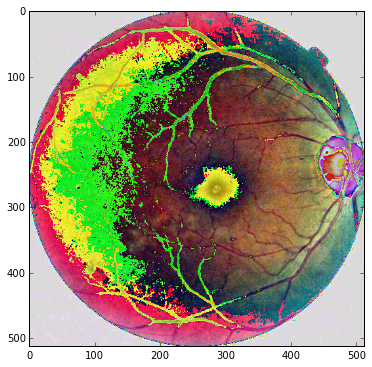

In [211]:
plt.imshow(img[0])